<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/Comparsion_of_process_simulation_using_neqsim%2C_UNSIM_and_DWSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install neqsim --upgrade
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt
from neqsim import jneqsim as neqsim

This workbook has been updated 9.10.2024 to work with release 3 of neqsim.

# Scope of work

In  this workbook we establish a neqsim simulation of a typical offshore oil and gas process and compare to results from HYSYS and DWSIM as presented in the work by A. Andreasen (https://github.com/andr1976/dwsim-paper).

Paper with results:

https://github.com/andr1976/dwsim-paper/blob/main/paper/Revised_Paper_ANRA.pdf

Fluid characterization given in paper:

https://onlinelibrary.wiley.com/doi/abs/10.1002/apj.159

Background info:

https://www.mdpi.com/2305-7084/4/1/11

# Create well fluid
The well fluid is created based on fluid characterization given in the papers.

In [2]:
wellfluid = neqsim.thermo.system.SystemPrEos()
#wellfluid.getCharacterization().setTBPModel("Twu")
wellfluid.addComponent("CO2", 1.5870)
wellfluid.addComponent("methane", 52.51)
wellfluid.addComponent("ethane", 6.24)
wellfluid.addComponent("propane", 4.23)
wellfluid.addComponent("i-butane", 0.855)
wellfluid.addComponent("n-butane", 2.213)
wellfluid.addComponent("i-pentane", 1.124)
wellfluid.addComponent("n-pentane", 1.271)
wellfluid.addComponent("n-hexane", 2.289)
wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.9575)
wellfluid.setMixingRule("classic")
#wellfluid.setMultiPhaseCheck(True) #not needed as we will have maximum two phases
#wellfluid.useVolumeCorrection(False) #It seems as volume correction was not used in the papers. To be checked.

Alternative use the Eclipse fluid model configuration script to create the fluid

In [3]:
from neqsim.thermo.thermoTools import readEclipseFluid, printFrame, TPflash
wellfluid_eclipse = readEclipseFluid('examplefile.txt')
wellfluid_eclipse.setMultiPhaseCheck(True)
#TPflash(wellfluid_eclipse)
#printFrame (wellfluid_eclipse)

Run a TPflash on well fluid at standard conditions and report the properties presented in the papers.

In [4]:
from neqsim.thermo.thermoTools import printFrame, TPflash
wellfluid.setPressure(0.0, "barg")
wellfluid.setTemperature(15.0, "C")
TPflash(wellfluid)
printFrame (wellfluid)

print('GOR ', wellfluid.getPhase("gas").getNumberOfMolesInPhase()/wellfluid.getPhase("oil").getNumberOfMolesInPhase())
print('Gas molecular weight ', wellfluid.getPhase("gas").getMolarMass('gr/mol'))
print('Oil molecular weight ', wellfluid.getPhase("oil").getMolarMass('gr/mol'))
print('gas density ',  wellfluid.getPhase("gas").getDensity('kg/m3'))
print('oil density ',  wellfluid.getPhase("oil").getDensity('kg/m3'))

| 0                    | 1          | 2           | 3           | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:------------|:----|:----|:----------------|
|                      | total      | GAS         | OIL         |     |     |                 |
| CO2                  | 1.58867E-2 | 2.30273E-2  | 3.72296E-4  |     |     | [mole fraction] |
| methane              | 5.25654E-1 | 7.65615E-1  | 4.28471E-3  |     |     | [mole fraction] |
| ethane               | 6.24658E-2 | 8.96751E-2  | 3.34769E-3  |     |     | [mole fraction] |
| propane              | 4.23446E-2 | 5.79046E-2  | 8.53708E-3  |     |     | [mole fraction] |
| i-butane             | 8.55902E-3 | 1.06321E-2  | 4.05486E-3  |     |     | [mole fraction] |
| n-butane             | 2.21533E-2 | 2.55798E-2  | 1.47086E-2  |     |     | [mole fraction] |
| i-pentane            | 1.12519E-2 | 9.61623E-3  | 1.48056E-2  |     |     | [mole fraction] |
| n-pentane            | 1.27234E-2 | 9.

# Phase envelope and critical properties of the well fluid

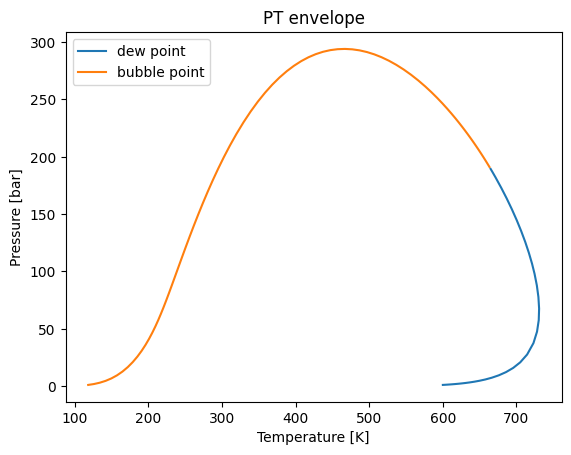

cricobarP  294.08912651859504   bara   cricobarT  466.9955283081695  K
cricothermP  67.65215087599485   bara   cricothermT  730.8426155007827  K
critical temperature  [K]  661.9272705180886  critical pressure  [bara]  192.7072071731752


In [5]:
import matplotlib.pyplot as plt

thermoOps = neqsim.thermodynamicoperations.ThermodynamicOperations(wellfluid.clone())
thermoOps.calcPTphaseEnvelope2()

plt.plot(list(thermoOps.getOperation().get("dewT")),list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot(list(thermoOps.getOperation().get("bubT")),list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

cricobar = thermoOps.getOperation().get("cricondenbar")
cricotherm = thermoOps.getOperation().get("cricondentherm")
print("cricobarP ",  cricobar[1], "  bara ", " cricobarT ", cricobar[0], " K")
print("cricothermP ",  cricotherm[1], "  bara ", " cricothermT ", cricotherm[0], " K")
print('critical temperature  [K] ', thermoOps.getOperation().get("criticalPoint1")[0], ' critical pressure  [bara] ', thermoOps.getOperation().get("criticalPoint1")[1] )

# Establish the process model using NeqSim
In this notebook we will use the pydantic framework for implementing the model. This framework is well suited for implementing the model as an API, enables checking of validity of input parameters, API documentation, and  enables fast implementation of the model in a cloud framework (eg. used for running live process simulation or use in process digital twins).

In [8]:
import pandas as pd
from pydantic.dataclasses import dataclass
from typing import Optional, List
from pydantic import Field, field_validator
import json

@dataclass
class ProcessInput():
    """
    A class to define input parameters for the process.
    """
    feed_rate: float = Field(title="molar flow rate [kgmole/hr]")
    molar_composition: List[float] = Field(title="molar composition of well fluid [molefraction]")
    Psep1: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [barg]")
    Tsep1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    Psep2: float = Field(ge=0.0, le=100.0, title="Pressure of firs seccondt stage separator [barg]")
    Tsep2: float = Field(ge=0.0, le=100.0, title="Temperature of seccond stage separator [C]")
    Psep3: float = Field(ge=0.0, le=100.0, title="Pressure of firs third stage separator [barg]")
    Tsep3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage separator [C]")
    Tscrub1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage recompressor scrubber [C]")
    Tscrub2: float = Field(ge=0.0, le=100.0, title="Temperature of seccond stage recompressor scrubber [C]")
    Tscrub3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage recompressor scrubber [C]")
    Tscrub4: float = Field(ge=0.0, le=100.0, title="Temperature of fourth stage recompressor scrubber [C]")
    Pcomp1: float = Field(ge=0.0, le=100.0, title="Pressure after 1st stage export compressor [barg]")
    Trefig: float = Field(ge=0.0, le=100.0, title="Temperature after cooling export gas [C]")
    P_oil_export: float = Field(ge=0.0, le=200.0, title="Pressure after oil export pump [barg]")
    T_oil_export: float = Field(ge=0.0, le=100.0, title="Temperature of export oil [C]")
    P_gas_export: float = Field(ge=0.0, le=300.0, title="Pressure of exort gas [barg]")
    T_gas_export: float = Field(ge=0.0, le=100.0, title="Temperature of export gas [C]")
    dP_20_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_20_HA_02:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_20_HA_03:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_21_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_23_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_23_HA_02:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_23_HA_03:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_24_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_25_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_25_HA_02:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")
    dP_27_HA_01:  float = Field(ge=0.0, le=10.0, title="Pressure drop over heater[bar]")

    @field_validator('molar_composition')
    def check_mole_rates(cls, v):
        if len(v) != 17:
            raise ValueError('fluidcomposition should have 17 components ')
        return v

@dataclass
class ProcessOutput:
    """
    A class to define output results from an Oil process simulation.
    """
    mass_balance: Optional[float] = None
    results: Optional[dict] = None  # Change the type to dict

def getprocess():
    """
    The method creates an oil process object using neqsim
    """

    wellstream = neqsim.processsimulation.processequipment.stream.Stream("well stream", wellfluid)
    wellstream.setTemperature(60.0, 'C')
    wellstream.setPressure(33.01, 'bara')

    well_stream_cooler = neqsim.processsimulation.processequipment.heatexchanger.Heater("20-HA-01", wellstream)

    first_stage_separator = neqsim.processsimulation.processequipment.separator.ThreePhaseSeparator("20-VA-01", well_stream_cooler.getOutStream())

    oilvalve1 = neqsim.processsimulation.processequipment.valve.ThrottlingValve("VLV-100", first_stage_separator.getOilOutStream())

    oil_2nd_stage_mixer = neqsim.processsimulation.processequipment.mixer.Mixer("MIX-101")
    oil_2nd_stage_mixer.addStream(oilvalve1.getOutStream())

    oilHeaterFromFirstStage = neqsim.processsimulation.processequipment.heatexchanger.Heater("20-HA-02", oil_2nd_stage_mixer.getOutStream())

    seccond_stage_separator = neqsim.processsimulation.processequipment.separator.ThreePhaseSeparator("20-VA-02", oilHeaterFromFirstStage.getOutStream())

    oilvalve2 = neqsim.processsimulation.processequipment.valve.ThrottlingValve("VLV-102", seccond_stage_separator.getOilOutStream())

    oilreflux =  wellstream.clone()
    oilreflux.setName("third stage reflux")
    oilreflux.setFlowRate(1e-6, 'kg/hr')

    thirdstageoilmixer = neqsim.processsimulation.processequipment.mixer.Mixer("MIX-102")
    thirdstageoilmixer.addStream(oilvalve2.getOutStream())
    thirdstageoilmixer.addStream(oilreflux)

    oilHeaterFromSeccondStage = neqsim.processsimulation.processequipment.heatexchanger.Heater("20-HA-03", thirdstageoilmixer.getOutletStream())

    third_stage_separator = neqsim.processsimulation.processequipment.separator.ThreePhaseSeparator("20-VA-03", oilHeaterFromSeccondStage.getOutStream())

    firstStageCooler = neqsim.processsimulation.processequipment.heatexchanger.Cooler("23-HA-03", third_stage_separator.getGasOutStream())

    firstStageScrubber = neqsim.processsimulation.processequipment.separator.Separator("23-VG-03", firstStageCooler.getOutStream())

    firststagescrubberpump = neqsim.processsimulation.processequipment.pump.Pump("23-PA-01", firstStageScrubber.getLiquidOutStream())

    lp_resycle = neqsim.processsimulation.processequipment.util.Recycle("LP oil resycle")
    lp_resycle.addStream(firststagescrubberpump.getOutStream())
    lp_resycle.setOutletStream(oilreflux)
    lp_resycle.setTolerance(1e-6)

    first_stage_recompressor = neqsim.processsimulation.processequipment.compressor.Compressor("23-KA-03", firstStageScrubber.getGasOutStream())
    first_stage_recompressor.setIsentropicEfficiency(0.75)

    firststagegasmixer = neqsim.processsimulation.processequipment.mixer.Mixer("MIX-103")
    firststagegasmixer.addStream(first_stage_recompressor.getOutStream())
    firststagegasmixer.addStream(seccond_stage_separator.getGasOutStream())

    seccond_stage_cooler = neqsim.processsimulation.processequipment.heatexchanger.Cooler("23-HA-02", firststagegasmixer.getOutStream())

    seccond_stage_scrubber = neqsim.processsimulation.processequipment.separator.Separator("23-VG-02", seccond_stage_cooler.getOutStream())

    thirdstageoilmixer.addStream(seccond_stage_scrubber.getLiquidOutStream())

    seccond_stage_recompressor = neqsim.processsimulation.processequipment.compressor.Compressor("23-KA-02", seccond_stage_scrubber.getGasOutStream())
    seccond_stage_recompressor.setIsentropicEfficiency(0.75)

    exportgasmixer = neqsim.processsimulation.processequipment.mixer.Mixer("MIX-100")
    exportgasmixer.addStream(seccond_stage_recompressor.getOutStream())
    exportgasmixer.addStream(first_stage_separator.getGasOutStream())

    dew_point_cooler = neqsim.processsimulation.processequipment.heatexchanger.Cooler("23-HA-01", exportgasmixer.getOutStream())

    dew_point_scrubber = neqsim.processsimulation.processequipment.separator.Separator("23-VG-01", dew_point_cooler.getOutStream())

    oil_2nd_stage_mixer.addStream(dew_point_scrubber.getLiquidOutStream())

    first_stage_export_compressor = neqsim.processsimulation.processequipment.compressor.Compressor("23-KA-01", dew_point_scrubber.getGasOutStream())
    first_stage_export_compressor.setIsentropicEfficiency(0.75)

    dew_point_cooler2 = neqsim.processsimulation.processequipment.heatexchanger.Cooler("24-HA-01", first_stage_export_compressor.getOutStream())

    dew_point_scrubber2 = neqsim.processsimulation.processequipment.separator.Separator("24-VG-01", dew_point_cooler2.getOutStream())

    oil_2nd_stage_mixer.addStream(dew_point_scrubber2.getLiquidOutStream())

    gas_splitter = neqsim.processsimulation.processequipment.splitter.Splitter('splitter', dew_point_scrubber2.getGasOutStream())
    gas_splitter.setSplitNumber(2)
    gas_splitter.setFlowRates([-1, 2966.0], "kg/hr")

    fuel_gas = gas_splitter.getSplitStream(1);
    fuel_gas.setName('fuel gas')

    gas_heatexchanger = neqsim.processsimulation.processequipment.heatexchanger.HeatExchanger("25-HA-01", gas_splitter.getSplitStream(0))
    gas_heatexchanger.setGuessOutTemperature(273.15 + 15.0)
    gas_heatexchanger.setUAvalue(800e3)

    dew_point_cooler3 = neqsim.processsimulation.processequipment.heatexchanger.Cooler("25-HA-02", gas_heatexchanger.getOutStream(0))

    dew_point_scrubber3 = neqsim.processsimulation.processequipment.separator.Separator("25-VG-01", dew_point_cooler3.getOutStream())

    exportgasmixer.addStream(dew_point_scrubber3.getLiquidOutStream())

    gas_heatexchanger.setFeedStream(1, dew_point_scrubber3.getGasOutStream())

    seccond_stage_export_compressor = neqsim.processsimulation.processequipment.compressor.Compressor("27-KA-01", gas_heatexchanger.getOutStream(1))
    seccond_stage_export_compressor.setIsentropicEfficiency(0.75)

    export_compressor_cooler = neqsim.processsimulation.processequipment.heatexchanger.Cooler("27-HA-01", seccond_stage_export_compressor.getOutStream())

    export_gas = export_compressor_cooler.getOutStream();
    export_gas.setName('export gas')

    export_oil_cooler = neqsim.processsimulation.processequipment.heatexchanger.Cooler("21-HA-01", third_stage_separator.getOilOutStream())

    export_oil_pump = neqsim.processsimulation.processequipment.pump.Pump("21-PA-01", export_oil_cooler.getOutStream())

    export_oil = export_oil_pump.getOutStream();
    export_oil.setName('export oil')

    oilprocess = neqsim.processsimulation.processsystem.ProcessSystem()
    oilprocess.add(wellstream)
    oilprocess.add(well_stream_cooler)
    oilprocess.add(first_stage_separator)
    oilprocess.add(oilvalve1)
    oilprocess.add(oil_2nd_stage_mixer)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(seccond_stage_separator)
    oilprocess.add(oilvalve2)
    oilprocess.add(oilreflux)
    oilprocess.add(thirdstageoilmixer)
    oilprocess.add(oilHeaterFromSeccondStage)
    oilprocess.add(third_stage_separator)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firststagescrubberpump)
    oilprocess.add(lp_resycle)
    oilprocess.add(first_stage_recompressor)
    oilprocess.add(firststagegasmixer)
    oilprocess.add(seccond_stage_cooler)
    oilprocess.add(seccond_stage_scrubber)
    oilprocess.add(seccond_stage_recompressor)
    oilprocess.add(exportgasmixer)
    oilprocess.add(dew_point_cooler)
    oilprocess.add(dew_point_scrubber)
    oilprocess.add(first_stage_export_compressor)
    oilprocess.add(dew_point_cooler2)
    oilprocess.add(dew_point_scrubber2)
    oilprocess.add(gas_splitter)
    oilprocess.add(gas_heatexchanger)
    oilprocess.add(dew_point_cooler3)
    oilprocess.add(dew_point_scrubber3)
    oilprocess.add(seccond_stage_export_compressor)
    oilprocess.add(export_compressor_cooler)
    oilprocess.add(export_oil_cooler)
    oilprocess.add(export_oil_pump)
    oilprocess.add(export_gas)
    oilprocess.add(export_oil)
    oilprocess.add(fuel_gas)

    return oilprocess

def updateinput(process, locinput):
    """
    Update process with input parameters. Error handling added for non-existing units.
    """
    # Try accessing each unit and catch any potential AttributeError
    try:
      process.getUnit('well stream').setFlowRate(locinput.feed_rate*1e3/3600,'mol/sec')
      process.getUnit('well stream').getFluid().setMolarComposition(locinput.molar_composition)
      process.getUnit('well stream').setPressure(locinput.Psep1+locinput.dP_20_HA_01, "barg")
      process.getUnit('well stream').setTemperature(60.0, "C")
      process.getUnit('20-HA-01').setOutTemperature(locinput.Tsep1, "C")
      process.getUnit('20-HA-01').setOutPressure(locinput.Psep1, "barg")
      process.getUnit('VLV-100').setOutletPressure(locinput.Psep2+locinput.dP_20_HA_02,'barg')
      process.getUnit('20-HA-02').setOutTemperature(locinput.Tsep2,'C')
      process.getUnit('20-HA-02').setOutPressure(locinput.Psep2,'barg')
      process.getUnit('VLV-102').setOutletPressure(locinput.Psep3+locinput.dP_20_HA_03,'barg')
      process.getUnit('20-HA-03').setOutTemperature(locinput.Tsep3,'C')
      process.getUnit('20-HA-03').setOutPressure(locinput.Psep3,'barg')
      process.getUnit('23-HA-03').setOutTemperature(locinput.Tscrub1,'C')
      process.getUnit('23-HA-03').setOutPressure(locinput.Psep3-locinput.dP_20_HA_03,'barg')

      process.getUnit('23-PA-01').setPressure(locinput.Psep3+locinput.dP_20_HA_03, 'barg')
      process.getUnit('23-KA-03').setOutletPressure(locinput.Psep2,'barg')

      process.getUnit('23-HA-02').setOutTemperature(locinput.Tscrub2,'C')
      process.getUnit('23-HA-02').setOutPressure(locinput.Psep2-locinput.dP_23_HA_02, 'barg')

      process.getUnit('23-KA-02').setOutletPressure(locinput.Psep1,'barg')
      process.getUnit('23-KA-01').setOutletPressure(locinput.Pcomp1,'barg')

      process.getUnit('23-HA-01').setOutTemperature(locinput.Tscrub3,'C')
      process.getUnit('23-HA-01').setOutPressure(locinput.Psep1-locinput.dP_23_HA_01,'barg')

      process.getUnit('24-HA-01').setOutTemperature(locinput.Tscrub4,'C')
      process.getUnit('24-HA-01').setOutPressure(locinput.Pcomp1-locinput.dP_24_HA_01,'barg')
      process.getUnit('27-KA-01').setOutletPressure(locinput.P_gas_export,'barg')

      process.getUnit('25-HA-02').setOutTemperature(locinput.Trefig,'C')
      process.getUnit('25-HA-02').setOutPressure(locinput.Pcomp1-locinput.dP_25_HA_01-locinput.dP_20_HA_02,'barg')

      process.getUnit('21-HA-01').setOutTemperature(locinput.T_oil_export,'C')
      process.getUnit('21-HA-01').setOutPressure(locinput.Psep3-locinput.dP_21_HA_01,'barg')
      process.getUnit('21-PA-01').setOutletPressure(locinput.P_oil_export+1.01325)

      process.getUnit('27-HA-01').setOutTemperature(40.0,'C')
      process.getUnit('27-HA-01').setOutletPressure(locinput.P_oil_export-locinput.dP_27_HA_01)


    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")

def getoutput(process):
    json_report= str(neqsim.processsimulation.util.report.Report(process).generateJsonReport())

    return {
        'results': json.loads(json_report),
        'mass_balance': (process.getUnit('well stream').getFlowRate('kg/hr')-process.getUnit('fuel gas').getFlowRate('kg/hr')-process.getUnit('27-KA-01').getOutStream().getFlowRate('kg/hr')-process.getUnit('20-VA-03').getOilOutStream().getFlowRate('kg/hr'))/process.getUnit('well stream').getFlowRate('kg/hr')*100
    }

def run_simulation(process, input_params, timeout=60):
    """Run the oil process calculation with a specified timeout."""
    updateinput(process=process, locinput=ProcessInput(**input_params))
    thread = process.runAsThread()
    thread.join(timeout*1000)
    if thread.isAlive():
        print('Process calculation timed out. Consider recreating the process object or adjusting parameters.')
        return None
    return ProcessOutput(**getoutput(process=process))

# Create the process model

In [9]:
process1 = getprocess()

#Run calculation
Input parameters are passed as a Python struct. In this calculation we will use the input parameters as used in the base case in the paper.

In [10]:
inputparam = {
 'feed_rate': 8000.0,
 'molar_composition': list(wellfluid.getMolarComposition()),
 'Tsep1': 70.0,
 'Psep1': 31.5,
 'Psep2': 8.0,
 'Psep3': 1.5,
 'Tsep2': 68.2,
 'Tsep3': 65.0,
 'Tscrub1': 32.0,
 'Tscrub2': 32.0,
 'Tscrub3': 32.0,
 'Tscrub4': 30.0,
 'Pcomp1': 90.0,
 'Trefig': 10.0,
 'P_oil_export':60.0,
 'T_oil_export':48.5,
 'P_gas_export': 188.6,
 'T_gas_export': 40.0,
 'dP_20_HA_01':	0.5,
 'dP_20_HA_02':	0.5,
 'dP_20_HA_03':	0.5,
 'dP_21_HA_01':	0.5,
 'dP_23_HA_01':	0.3,
 'dP_23_HA_02':	1.0,
 'dP_23_HA_03':	1.0,
 'dP_24_HA_01':	1.0,
 'dP_25_HA_01':	0.5,
 'dP_25_HA_02':	0.5,
 'dP_27_HA_01':	0.0,
}

results = run_simulation(process=process1, input_params=inputparam)


# Evaluation of export gas and export oil streams

In [11]:
print('mass balance ', results.mass_balance)
print('gas export rate ',float(results.results['export gas']['conditions']['overall']['molar flow']['value'])/1e3, ' [kmole/hr]')
print('oil export rate ',float(results.results['export oil']['conditions']['overall']['molar flow']['value'])/1e3, ' [kmole/hr]')
print('oil molecular weight ',float(results.results['export oil']['properties']['overall']['molar mass']['value'])*1e3, ' [gr/mole]')
print('gas molecular weight ',float(results.results['export gas']['properties']['overall']['molar mass']['value'])*1e3, ' [gr/mole]')
print('RVP oil export ',float(results.results['export oil']['properties']['oil']['RVP']['value'])*14.5038, ' [psia] (37.8C)')
print('TVP oil export ',float(results.results['export oil']['properties']['oil']['TVP']['value']), 'bara')
print('GCV gas export ',float(results.results['export gas']['properties']['gas']['GCV']['value']), ' [MJ/Sm3] 15C/15C')
print('WI gas export ',float(results.results['export gas']['properties']['gas']['WI']['value']), ' [MJ/Sm3] 15C/15C')

mass balance  3.93749794232956e-05
gas export rate  5103.69584032564  [kmole/hr]
oil export rate  2760.1867976883545  [kmole/hr]
oil molecular weight  201.91007373099433  [gr/mole]
gas molecular weight  21.027108609534842  [gr/mole]
RVP oil export  10.05947595459478  [psia] (37.8C)
TVP oil export  1.72343211731166 bara
GCV gas export  45.61709346202231  [MJ/Sm3] 15C/15C
WI gas export  53.45679147743474  [MJ/Sm3] 15C/15C


# Evaluation of heater and cooler duties

In [12]:
print('20-HA-01 ', results.results['20-HA-01']['duty']/1e3, ' kW')
print('20-HA-03 ', results.results['20-HA-03']['duty']/1e3, ' kW')
print('21-HA-01 ', results.results['21-HA-01']['duty']/1e3, ' kW')
print('23-HA-01 ', results.results['23-HA-01']['duty']/1e3, ' kW')
print('23-HA-02 ', results.results['23-HA-02']['duty']/1e3, ' kW')
print('23-HA-03 ', results.results['23-HA-03']['duty']/1e3, ' kW')
print('24-HA-01 ', results.results['24-HA-01']['duty']/1e3, ' kW')
print('25-HA-01 ', results.results['25-HA-01']['duty']/1e3, ' kW')
print('25-HA-02 ', results.results['25-HA-02']['duty']/1e3, ' kW')
print('27-HA-01 ', results.results['27-HA-01']['duty']/1e3, ' kW')

20-HA-01  4187.005814305898  kW
20-HA-03  -517.3950616419837  kW
21-HA-01  -5140.214802291699  kW
23-HA-01  -2645.5150408276  kW
23-HA-02  -531.0843312246634  kW
23-HA-03  -115.02905489250234  kW
24-HA-01  -8369.107070121474  kW
25-HA-01  1863.4550947629516  kW
25-HA-02  -557.8824828579062  kW
27-HA-01  -4670.6015357063025  kW


In [13]:
results.results['25-HA-01']

{'name': '25-HA-01',
 'feedTemperature1': 30.0,
 'dischargeTemperature1': 14.33442634215146,
 'HXthermalEfectiveness': 0.951796625864554,
 'feedTemperature2': 10.0,
 'dischargeTemperature2': 28.96870115341011,
 'dutyBalance': 1.0,
 'duty': 1863455.0947629516,
 'UAvalue': 800000.0}

# Evaluation of compressor simulations

In [14]:
print('power')
print('23-KA-01 ', results.results['23-KA-01']['power'], ' kW')
print('23-KA-02 ', results.results['23-KA-02']['power'], ' kW')
print('23-KA-03 ', results.results['23-KA-03']['power'], ' kW')
print('27-KA-01 ', results.results['27-KA-01']['power'], ' kW')
print('21-PA-01 ', results.results['21-PA-01']['power']/1e3, ' kW')
print('discharge temperatures')
print('23-KA-01 ', results.results['23-KA-01']['dischargeTemperature'], ' C')
print('23-KA-02 ', results.results['23-KA-02']['dischargeTemperature'], ' C')
print('23-KA-03 ', results.results['23-KA-03']['dischargeTemperature'], ' C')
print('27-KA-01 ', results.results['27-KA-01']['dischargeTemperature'], ' C')
print('21-PA-01 ', results.results['21-PA-01']['dischargeTemperature'], ' C')

power
23-KA-01  5282.093377596974  kW
23-KA-02  807.6245745118796  kW
23-KA-03  269.33760676903313  kW
27-KA-01  2942.9766635476576  kW
21-PA-01  1168.8948678554445  kW
discharge temperatures
23-KA-01  120.35233940991179  C
23-KA-02  127.71560307112219  C
23-KA-03  112.69187559952871  C
27-KA-01  88.87839107336214  C
21-PA-01  49.107526609653405  C


In [15]:
results.results['27-KA-01']

{'name': '27-KA-01',
 'suctionTemperature': 28.96870115341011,
 'dischargeTemperature': 88.87839107336214,
 'suctionPressure': 90.01325,
 'dischargePressure': 189.61325,
 'polytropicHead': 74.043380799918,
 'polytropicEfficiency': 0.75,
 'power': 2942.9766635476576,
 'suctionVolumeFlow': 1062.1405849051096,
 'dischargeVolumeFlow': 702.8642181756709,
 'molarMass': 0.021027108609534842,
 'suctionMassDensity': 100.21775346917387,
 'dischargeMassDensity': 152.68378154617673,
 'massflow': 107315.96674455843,
 'speed': 3000.0}

# Run 100 simulations with varying input parameters
In the following example we assume each input parameter can vary maximum 10%.

In [16]:
import numpy as np
import random


def vary_parameter(param_value, variation=0.1):
    """
    Vary the parameter value by a given percentage.
    """
    if isinstance(param_value, (list, np.ndarray)):
        return param_value  # Don't vary list/array type parameters
    else:
        return param_value * (1 + random.uniform(-variation, variation))

# Function to run the simulation
def run_simulation_variations(base_params, num_simulations=100, variation=0.1):
    results = []
    for i in range(num_simulations):
        print('running simulation ' ,i)
        varied_params = {}
        for key, value in base_params.items():
            if isinstance(value, (list, np.ndarray)):
                varied_params[key] = value  # Don't vary list/array type parameters
            else:
                varied_params[key] = vary_parameter(value, variation)
        result = run_simulation(process=process1, input_params=varied_params)
        results.append(result)
    return results

# Run the simulations
simulation_results = run_simulation_variations(inputparam)

# Process the results as needed
for idx, result in enumerate(simulation_results):
    print(f"Simulation {idx + 1}: {result}")


running simulation  0
running simulation  1
running simulation  2
running simulation  3
running simulation  4
running simulation  5
running simulation  6
running simulation  7
running simulation  8
running simulation  9
running simulation  10
running simulation  11
running simulation  12
running simulation  13
running simulation  14
running simulation  15
running simulation  16
running simulation  17
running simulation  18
running simulation  19
running simulation  20
running simulation  21
running simulation  22
running simulation  23
running simulation  24
running simulation  25
running simulation  26
running simulation  27
running simulation  28
running simulation  29
running simulation  30
running simulation  31
running simulation  32
running simulation  33
running simulation  34
running simulation  35
running simulation  36
running simulation  37
running simulation  38
running simulation  39
running simulation  40
running simulation  41
running simulation  42
running simulation  4

# Optimization of the process
...to be looked into

# Save/serialize simulation object to file and read/deserialize from file

In [17]:
# Example of how to save a process simulation to a file
# XML serialize and save the process1 object to a file

from neqsim import save_xml, open_xml

# Save the simulation object to the file 'process1.xml'
save_xml(process1, 'process1.xml');

# Read the 'process1.xml' file and deserialize it into a process simulation object 'process2'
process2 = open_xml('process1.xml');

# Access and print the flow rate of the 'well stream' unit in 'kg/hr'
flow_rate = process2.getUnit('well stream').getFlowRate('kg/hr')
print(f"Flow rate: {flow_rate} kg/hr")

Flow rate: 680604.2608441772 kg/hr
